# Finetune a BERT model with your text data.

Esta notebook carga un modelo de BERT ya entrenado](ver el nombre del modelo en  BERT_MODEL) y hace finetuning del modelo.

Código basado en [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning).

In [ ]:
!pip install transformers
!pip install torch

import torch

# Hay una GPU disponible?
is_gpu = torch.cuda.is_available()
if is_gpu:    
    # Decile a PyTorch que use la GPU.    
    device = torch.device("cuda")
    print(f'\nHay {torch.cuda.device_count()} GPU(s) disponible(s).')
    print(f'Vamos a usar la GPU: {torch.cuda.get_device_name(0)}.\n')
# si no hay GPU...
else:
    print('\nNo hay GPU disponible, vamos a usar la CPU.\n')
    device = torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Hay 1 GPU(s) disponible(s).
Vamos a usar la GPU: Tesla T4.



In [ ]:
# Cargar el tokenizador correspondiente al modelo de BERT que vamos a usar.
from transformers import BertTokenizer

# Este es el nombre en Huggingface del modelo de BERT ya entrenado que vamos a usar.
# Ver https://huggingface.co/models?language=es&sort=downloads para mas modelos en castellano.
BERT_MODEL = 'dccuchile/bert-base-spanish-wwm-cased' #CAMBIO RESPECTO ORIGINAL
# Otros posibles modelos p.ej.:
#   'dccuchile/bert-base-spanish-wwm-cased'
#   'mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es'
#   'Recognai/bert-base-spanish-wwm-cased-xnli'
print('Cargando tokenizador de BERT...')
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
print('\nTokenizador de BERT listo.')

Cargando tokenizador de BERT...

Tokenizador de BERT listo.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
# Aqui ud. debe cargar su dataset para hacer finetuning.
# my_dataset = ....

df = pd.read_csv("/content/drive/MyDrive/Austral/Web minning/notas_completo.csv", sep=",")
df = df[df["Sentence"].notna()]
df = df[df["label"].notna()]
df = df[df["Time"].notna()]

my_dataset = df[df["Time"]<"2022-08-01"]
my_dataset = my_dataset[["Sentence","label"]]
my_dataset = my_dataset[my_dataset["Sentence"].notna()]
my_dataset = my_dataset[my_dataset["label"].notna()]
my_dataset = my_dataset.rename(columns={'Sentence':'sentence','label':'label'})
train, test = train_test_split(my_dataset, test_size = 0.10)
my_dataset = train

#ARMAR DOS DATASET NOTICIAS VIEJAS VS NUEVAS

df_Agosto2022 = df[df["Time"]>="2022-08-01"]
df_validacion = test

# IMPORTANTE:
# 1) Su dataset debe ser un dataframe de Pandas con 2 columnas: 'sentence' conteniendo el texto sin tokenizar, y 'label' conteniendo la categoria correspondiente.
# 2) BERT no acepta mas de 512 tokens por frase. MY_DATASET_MAX_TOKENS es el maximo de tokens por frase que vamos a usar, el resto de descarta.
# Si hay menos de 512 tokens el tokenizer va a llenar el resto con el token PAD. 
MY_DATASET_MAX_TOKENS = 400 #ANTES 125.Cuidado que va a ser mas lento.
if MY_DATASET_MAX_TOKENS>512:
  raise ValueError(f"ERROR: BERT no puede codificar frases con mas de 512 tokens, pero MY_DATASET_MAX_TOKENS = {MY_DATASET_MAX_TOKENS}.")

# Si LAYERS_TO_FINETUNE==2, entonces conservamos los pesos de todas excepto la ultma capa de encoding y
# hacemos finetuning the la ultima capa de encodign y  la capa de clasificacion.
# Si es LAYERS_TO_FINETUNE>2, entonces hacemos finetuning the las ultimas LAYERS_TO_FINETUNE (hasta 12) capa de encoding y de la capa de clasificacion.
# Si LAYERS_TO_FINETUNE==1, hacemos finetuning solo de la capa de clasificacion, entrena mas rápido pero adapta menos pesos.
LAYERS_TO_FINETUNE=2 #ANTES 1 (Entre 2 y 4 suele ser el que mejor anda) ojo que mientras mas, mas lento es el entrenamiento.
if LAYERS_TO_FINETUNE<1 or LAYERS_TO_FINETUNE>13:
  raise ValueError("LAYERS_TO_FINETUNE no puede ser menor a 1 o mayor a 13, poque BERT tiene 12 capas de encoder + 1 de clasificacion.")

# Que porcentaje del dataset vamos a usar para entrenar ?
TRAIN_FOR_PCT = 0.6 #Antes 0.7
TRAIN_FOLD_SIZE = int(TRAIN_FOR_PCT * len(my_dataset))

# Number of training epochs. The BERT authors recommend between 2 and 4
# for over 1000 examples.
# We chose to run for 4, but this may be over-fitting the
# training data.
EPOCHS = 3 #ANTES 12. USAR 4 EPOCS PARA REDUCIR OVERFITTING ESPECIALMENTE SI TENEMOS MAS DE 1000 ejemplos.

In [ ]:
# Crear las listas de frases labels numéricosx
sentences = my_dataset.sentence.values
# labels en BERT DEBEN SER enteros; aqui transformos los valores de los labels
# a ints (mismo int, mismo valor), comenzando por 0.
labels, label_texts = pd.factorize(my_dataset.label)

# reordenar filas del dataset al azar; importante para el descenso de gradiente estocastico
my_dataset = my_dataset.iloc[np.random.permutation(len(my_dataset))]
my_dataset.reset_index(drop=True)

# MI_DATASET_NUM_LABELS es la cantidad de categorias distintas en su columna 'label'.
MY_DATASET_NUM_LABELS = labels.max() + 1

In [ ]:
# codificar frases en su dataset
input_ids = []
attention_masks = []

# Por cada frase ...
for sent in sentences:
    # `encode_plus` va a :
    #   (1) Tokenizar la frase.
    #   (2) Poner el token `[CLS]` al comienzo de la frase.
    #   (3) Poner el token `[SEP]` al final de la frase.
    #   (4) Mapear tokens a sus IDs.
    #   (5) Rellenar o truncar la frase a `max_length`
    #   (6) Crear attention masks para los tokens [PAD].
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # frase a codificar.
                        add_special_tokens = True, # Agregar '[CLS]' y '[SEP]'
                        max_length = MY_DATASET_MAX_TOKENS,  # Rellenar frases cortas, truncar largas
                        padding='max_length',
                        truncation=True,
                        return_token_type_ids=True,
                        return_attention_mask = True,   # Construir attn. masks  (diferencian padding de non-padding).
                        return_tensors = 'pt',     # retornar los vectores de pytorchxs.
                   )
    
    # Agregar la frase codificada a la lista de frases
    input_ids.append(encoded_dict['input_ids'])
    
    # Agregar su correspondiente attention mask
    attention_masks.append(encoded_dict['attention_mask'])

# Convertiar las listas a tensores de Pytorch
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [ ]:
# Cargar modelo pre-entrenado

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Cargar un BertForSequenceClassification, que es un modelo de BERT pre entrenado
# con una capa de clasificación al final.
print('Cargando pesos de modelo BERT pre-entrenado...\n')
model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL, # Modelo a usar
    num_labels=MY_DATASET_NUM_LABELS, # cant. de categorias de mi dataset
    ignore_mismatched_sizes=True, # si el modelo pre-entrenado tiene distinta cant. de categorias que mi dataset, ignorar las categorias del pre-entrenado, total las vamos a cambiar.
    output_attentions = False, # El modelo debe retornat attention weights?
    output_hidden_states = False # El modelo debe retornar todos los pesos de las capas de NN?
)
print('\nEl modelo BERT pre-entrenado está listo.')

Cargando pesos de modelo BERT pre-entrenado...



Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi


El modelo BERT pre-entrenado está listo.


In [ ]:
#  setup para entrenar 

from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(TRAIN_FOLD_SIZE)
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'Tamaño dataset de entrenamiento: {train_size} muestras')
print(f'Tamaño dataset de validacion: {val_size} muestras')

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

from transformers import AdamW, BertConfig

#if FINETUNE_ONLY_CLASSIFICATION_LAYER:
  # BERT is made of 3 modules: bert, dropout, and classifier
  # here we freeze the weights of all layers but the classifier module
#  for name, param in model.named_parameters():
#    if 'classifier' not in name: # classifier module
#      param.requires_grad = False

# Tell pytorch to run this model on the GPU if possible
if is_gpu:
    model.cuda()

# optimizer and learning rate
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Tamaño dataset de entrenamiento: 4549 muestras
Tamaño dataset de validacion: 3034 muestras


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# loop de entrenamiento
import numpy as np

def flat_accuracy(preds, labels):
    """
    Esta funcion calcula accuracy de predicción de labels
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    """
    Recibe un timestamp en segundos y retorna un string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        #(loss_tensor, logits)
        trainstep_output  = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += trainstep_output.loss.item()

        # Perform a backward pass to calculate the gradients.
        trainstep_output.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            trainstep_output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += trainstep_output.loss.item()

        # Move logits and labels to CPU
        logits = trainstep_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    285.    Elapsed: 0:00:43.
  Batch    80  of    285.    Elapsed: 0:01:29.
  Batch   120  of    285.    Elapsed: 0:02:16.
  Batch   160  of    285.    Elapsed: 0:03:03.
  Batch   200  of    285.    Elapsed: 0:03:49.
  Batch   240  of    285.    Elapsed: 0:04:36.
  Batch   280  of    285.    Elapsed: 0:05:23.

  Average training loss: 0.49
  Training epcoh took: 0:05:28

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.32
  Validation took: 0:01:18

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    285.    Elapsed: 0:00:47.
  Batch    80  of    285.    Elapsed: 0:01:33.
  Batch   120  of    285.    Elapsed: 0:02:20.
  Batch   160  of    285.    Elapsed: 0:03:07.
  Batch   200  of    285.    Elapsed: 0:03:53.
  Batch   240  of    285.    Elapsed: 0:04:40.
  Batch   280  of    285.    Elapsed: 0:05:27.

  Average training loss: 0.25
  Training epcoh took: 0:05:32

Running Validation...
  Accuracy: 0.89
 

In [ ]:
# Mostrar una tabla con un resumen del proceso de entrenamiento.

import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.32,0.88,0:05:28,0:01:18
2,0.25,0.32,0.89,0:05:32,0:01:18
3,0.15,0.35,0.90,0:05:32,0:01:19


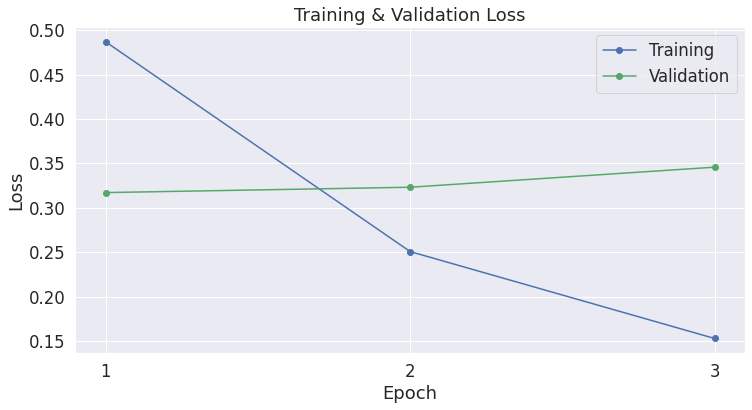

In [ ]:
# Dibujar un diagrama con train loss vs validation loss. Si todo sale bien,
# validation loss debería descender y estabilizarse, aunque igual puede hacer overfitting. 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1, EPOCHS+1)))

plt.show()

In [ ]:
# Guardar el modelo BERT con fine-tuning
import os
from pathlib import Path

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = Path('./bert_fine_tuned/')

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Guardando el modelo BERT con fine-tuning ee el directorio: {output_dir}")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
# save index to label mapping
with open(output_dir / "label_texts.txt", "wt") as f:
  f.write(label_texts[0])
  for label_text in label_texts[1:]:
      f.write('\n')
      f.write(label_text)


Guardando el modelo BERT con fine-tuning ee el directorio: bert_fine_tuned




```
# This is formatted as code
```

# En esta seccion probamos el modelo contra Agosto (Mes con el que no fue entrenado)

# Cargamos el modelo y creamos un dataframe con los resultados. 

In [3]:
from transformers import BertForSequenceClassification
model_dir = "./bert_fine_tuned/"
print(f"Cargando modelo de clasificación BERT con finetuning desde el directorio: {model_dir}...")
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)
with open(output_dir / "label_texts.txt", "rt") as f:
  label_texts = f.read().split('\n')
print(f"Modelo BERT en {model_dir} cargado.")

if is_gpu:
   # copiar el modelo desde CPU a GPU.
    model.to(device)

test_sentences = df_Agosto2022['Sentence']
predichos=pd.DataFrame(columns=["predicho","real"])

for sent in test_sentences:
    # `encode_plus` MUST use the same parameters used to fine tune.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MY_DATASET_MAX_TOKENS,  # Pad shorter sentences, or truncate all sentences longer than this
                        padding='max_length',
                        truncation=True,
                        return_token_type_ids=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    encoded_dict.to(device)
    print(encoded_dict["token_type_ids"].shape)
    
    output = model(**encoded_dict)
    # logits ARE NOT probabilities (but can be transformed into probabilities).
    # logits can be negative (means the probability is less than 0.5)
    agregar = {'predicho':label_texts[output.logits.argmax(dim=1).item()],'real':np.array2string(df_Agosto2022.where(sent == df_Agosto2022['Sentence']).dropna()['label'].values)}    
    predichos = predichos.append(agregar, ignore_index=True)
    print("Logits predichos: ",output.logits.cpu().detach(), "Clase predicha:", label_texts[output.logits.argmax(dim=1).item()], "Clase real:", df_Agosto2022['label'].where(sent == df_Agosto2022['Sentence']).dropna())
    

ModuleNotFoundError: ignored



```
# This is formatted as code
```
# Limpiamos el data frame para que quede con el formato necesario


In [ ]:
import re
#predichos = pd.DataFrame(data = ['[economia]','[el-mundo]','[sociedad]','[el-pais]'], columns=['real'])
for x in range(len(predichos)):
  predichos["real"][x] = re.sub("[^a-z]","",predichos["real"][x])
  predichos["predicho"][x] = re.sub("[^a-z]","",predichos["predicho"][x])
print(predichos)

      predicho      real
0     economia  economia
1     economia  economia
2     economia  economia
3     economia  economia
4     economia  economia
...        ...       ...
1560  sociedad  sociedad
1561  sociedad  sociedad
1562  sociedad  sociedad
1563  sociedad  sociedad
1564  sociedad  sociedad

[1565 rows x 2 columns]


In [ ]:
predichos.groupby(['real']).count()

,predicho
real,
economia,386
elmundo,225
elpais,530
sociedad,424


In [ ]:
predichos.groupby(['predicho']).count()

,real
predicho,
economia,386
elmundo,201
elpais,525
sociedad,453


Creamos matriz de confusion y metricas de analisis para El modelo aplicado a Agosto 2022

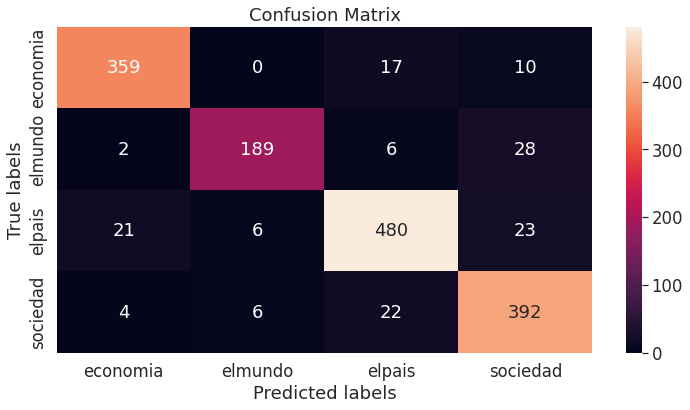

In [ ]:
from sklearn.metrics import confusion_matrix
import pylab as pl

cm = confusion_matrix(predichos["real"], predichos["predicho"])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['economia', 'elmundo', 'elpais', 'sociedad']); ax.yaxis.set_ticklabels(['economia','elmundo', 'elpais', 'sociedad']);

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy del modelo: ", accuracy_score(predichos["real"], predichos["predicho"]))
# Recall
from sklearn.metrics import recall_score
print("Recall del modelo: ", recall_score(predichos["real"], predichos["predicho"], average=None))
# Precision
from sklearn.metrics import precision_score
print("Precision del modelo: ", precision_score(predichos["real"], predichos["predicho"], average=None))
from sklearn.metrics import f1_score
print("F1_score del modelo: ", f1_score(predichos["real"], predichos["predicho"], average=None))
from sklearn.metrics import classification_report
print(classification_report(predichos["real"], predichos["predicho"], target_names=['economia', 'elmundo', 'elpais', 'sociedad']))

Accuracy del modelo:  0.9073482428115016
Recall del modelo:  [0.93005181 0.84       0.90566038 0.9245283 ]
Precision del modelo:  [0.93005181 0.94029851 0.91428571 0.86534216]
F1_score del modelo:  [0.93005181 0.88732394 0.90995261 0.89395667]
              precision    recall  f1-score   support

    economia       0.93      0.93      0.93       386
     elmundo       0.94      0.84      0.89       225
      elpais       0.91      0.91      0.91       530
    sociedad       0.87      0.92      0.89       424

    accuracy                           0.91      1565
   macro avg       0.91      0.90      0.91      1565
weighted avg       0.91      0.91      0.91      1565





```
# This is formatted as code
```

Aca repetimos el proceso anterior pero con un set de validacion separado del entrenamiento pero con en el mismo espacio temporal

In [ ]:
from transformers import BertForSequenceClassification
model_dir = "./bert_fine_tuned/"
print(f"Cargando modelo de clasificación BERT con finetuning desde el directorio: {model_dir}...")
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)
with open(output_dir / "label_texts.txt", "rt") as f:
  label_texts = f.read().split('\n')
print(f"Modelo BERT en {model_dir} cargado.")

if is_gpu:
   # copiar el modelo desde CPU a GPU.
    model.to(device)

test_sentences = df_validacion['sentence']
predichos_valid=pd.DataFrame(columns=["predicho","real"])

for sent in test_sentences:
    # `encode_plus` MUST use the same parameters used to fine tune.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MY_DATASET_MAX_TOKENS,  # Pad shorter sentences, or truncate all sentences longer than this
                        padding='max_length',
                        truncation=True,
                        return_token_type_ids=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    encoded_dict.to(device)
    print(encoded_dict["token_type_ids"].shape)
    
    output = model(**encoded_dict)
    # logits ARE NOT probabilities (but can be transformed into probabilities).
    # logits can be negative (means the probability is less than 0.5)
    agregar = {'predicho':label_texts[output.logits.argmax(dim=1).item()],'real':np.array2string(df_validacion.where(sent == df_validacion['sentence']).dropna()['label'].values)}    
    predichos_valid = predichos_valid.append(agregar, ignore_index=True)
    print("Logits predichos: ",output.logits.cpu().detach(), "Clase predicha:", label_texts[output.logits.argmax(dim=1).item()], "Clase real:", df_validacion['label'].where(sent == df_validacion['sentence']).dropna())
    

Cargando modelo de clasificación BERT con finetuning desde el directorio: ./bert_fine_tuned/...
Modelo BERT en ./bert_fine_tuned/ cargado.
torch.Size([1, 400])
Logits predichos:  tensor([[-1.4109, -0.1605,  4.3552, -2.6672]]) Clase predicha: economia Clase real: 1473    economia
Name: label, dtype: object
torch.Size([1, 400])
Logits predichos:  tensor([[ 4.7455, -1.2729, -2.2248, -0.2723]]) Clase predicha: sociedad Clase real: 5430    el-pais
Name: label, dtype: object
torch.Size([1, 400])
Logits predichos:  tensor([[ 3.7680, -2.1470, -1.8441,  0.8897]]) Clase predicha: sociedad Clase real: 8328    sociedad
Name: label, dtype: object
torch.Size([1, 400])
Logits predichos:  tensor([[-0.9872, -1.5979, -2.2323,  5.1111]]) Clase predicha: el-mundo Clase real: 2084    el-mundo
Name: label, dtype: object
torch.Size([1, 400])
Logits predichos:  tensor([[-1.5818, -1.8352, -2.1434,  5.2054]]) Clase predicha: el-mundo Clase real: 2253    el-mundo
Name: label, dtype: object
torch.Size([1, 400])
L

In [ ]:
#predichos = pd.DataFrame(data = ['[economia]','[el-mundo]','[sociedad]','[el-pais]'], columns=['real'])
for x in range(len(predichos_valid)):
  predichos_valid["real"][x] = re.sub("[^a-z]","",predichos_valid["real"][x])
  predichos_valid["predicho"][x] = re.sub("[^a-z]","",predichos_valid["predicho"][x])
print(predichos_valid)

     predicho      real
0    economia  economia
1    sociedad    elpais
2    sociedad  sociedad
3     elmundo   elmundo
4     elmundo   elmundo
..        ...       ...
838  economia  economia
839   elmundo   elmundo
840  sociedad  sociedad
841   elmundo   elmundo
842    elpais    elpais

[843 rows x 2 columns]


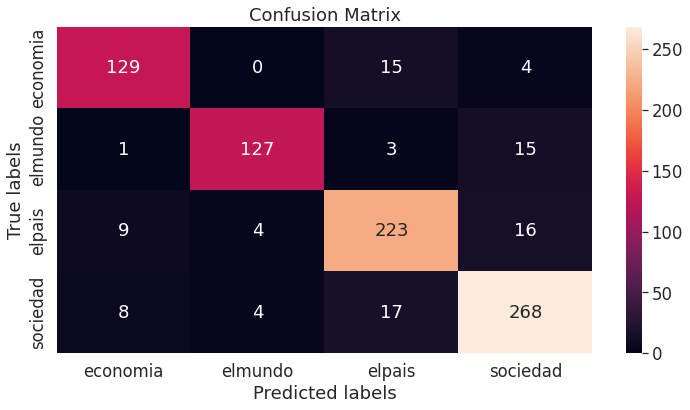

In [ ]:
cm2 = confusion_matrix(predichos_valid["real"], predichos_valid["predicho"])
ax2= plt.subplot()
sns.heatmap(cm2, annot=True, fmt='g', ax=ax2);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax2.set_xlabel('Predicted labels');ax2.set_ylabel('True labels'); 
ax2.set_title('Confusion Matrix'); 
ax2.xaxis.set_ticklabels(['economia', 'elmundo', 'elpais', 'sociedad']); ax2.yaxis.set_ticklabels(['economia','elmundo', 'elpais', 'sociedad']);

In [ ]:
# Accuracy
print("Accuracy del modelo: ", accuracy_score(predichos_valid["real"], predichos_valid["predicho"]))
# Recall
print("Recall del modelo: ", recall_score(predichos_valid["real"], predichos_valid["predicho"], average=None))
# Precision
print("Precision del modelo: ", precision_score(predichos_valid["real"], predichos_valid["predicho"], average=None))
#F1 Score
print("F1_score del modelo: ", f1_score(predichos_valid["real"], predichos_valid["predicho"], average=None))
from sklearn.metrics import classification_report
print(classification_report(predichos_valid["real"], predichos_valid["predicho"], target_names=['economia', 'elmundo', 'elpais', 'sociedad']))

Accuracy del modelo:  0.8861209964412812
Recall del modelo:  [0.87162162 0.86986301 0.88492063 0.9023569 ]
Precision del modelo:  [0.87755102 0.94074074 0.86434109 0.88448845]
F1_score del modelo:  [0.87457627 0.90391459 0.8745098  0.89333333]
              precision    recall  f1-score   support

    economia       0.88      0.87      0.87       148
     elmundo       0.94      0.87      0.90       146
      elpais       0.86      0.88      0.87       252
    sociedad       0.88      0.90      0.89       297

    accuracy                           0.89       843
   macro avg       0.89      0.88      0.89       843
weighted avg       0.89      0.89      0.89       843



Aca exportamos el set de entrenamiento utilizado, el set de validacion con el mismo espacio temporal y el set de validacion para Agosto 2022

In [4]:
my_dataset.to_csv('Dataset_entrenamiento.csv', header=True, index=False, encoding='utf-8')
df_Agosto2022.to_csv('Dataset_Valid_Agosto.csv', header=True, index=False, encoding='utf-8')
df_validacion.to_csv('Dataset_Valid.csv', header=True, index=False, encoding='utf-8')

In [5]:
from google.colab import files
files.download('Dataset_entrenamiento.csv')
files.download('Dataset_Valid_Agosto.csv')
files.download('Dataset_Valid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>